## Introduction
Each year due nearly 12 million deaths occur worldwide due to Heart diseases as estimated by World Health Organisation. More the 50% of these deaths are due to cardio vascular diseases, thus early identification of such diseases can help in making changes in the lifestyle of an individual to reduce complications and save the victim. This project aims in identifying most relevant risk factors as well as predict the overall risk of Heart disease using `Logistic Regression`.

In [3]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import scipy.stats as st
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

## Understanding the Data
* Source
    * The dataset is from an ongoing research on residents of the town of Framingham, Massachusetts. The goal is to predict the patients with 10-year risk of  coronary heart disease(CHD).

In [4]:
patientInfo = pd.read_csv('datasets/framingham.csv')
patientInfo.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
# Number of rows and features
patientInfo.shape

(4238, 16)

**Variables**<br>
Each attribute is a potential risk factor. There are both demographic, behavioral and medical risk factors.

1. Demographic:
    * Sex : Male or Female
    * Age : Age of the patient
    * Current Smoker : Whether or not the patient is a current smoker(Nominal)
    * Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)
2. Medical( history)
    * BP Meds: whether or not the patient was on blood pressure medication (Nominal)
    * Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
    * Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
    * Diabetes: whether or not the patient had diabetes (Nominal)
3. Medical(current)
    * Tot Chol: total cholesterol level (Continuous)
    * Sys BP: systolic blood pressure (Continuous)
    * Dia BP: diastolic blood pressure (Continuous)
    * BMI: Body Mass Index (Continuous)
    * Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
    * Glucose: glucose level (Continuous)

* Predict variable (desired target)
    * 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)


## EDA

In [6]:
# gender, male : 1 and female : 0
patientInfo.rename(columns={'male':'gender'},inplace=True)
patientInfo.shape

(4238, 16)

In [7]:
# checking for null values
patientInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [8]:
patientInfo.isna().sum()

gender               0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

So we can see that there are many null values especially for glucose and education

<AxesSubplot:>

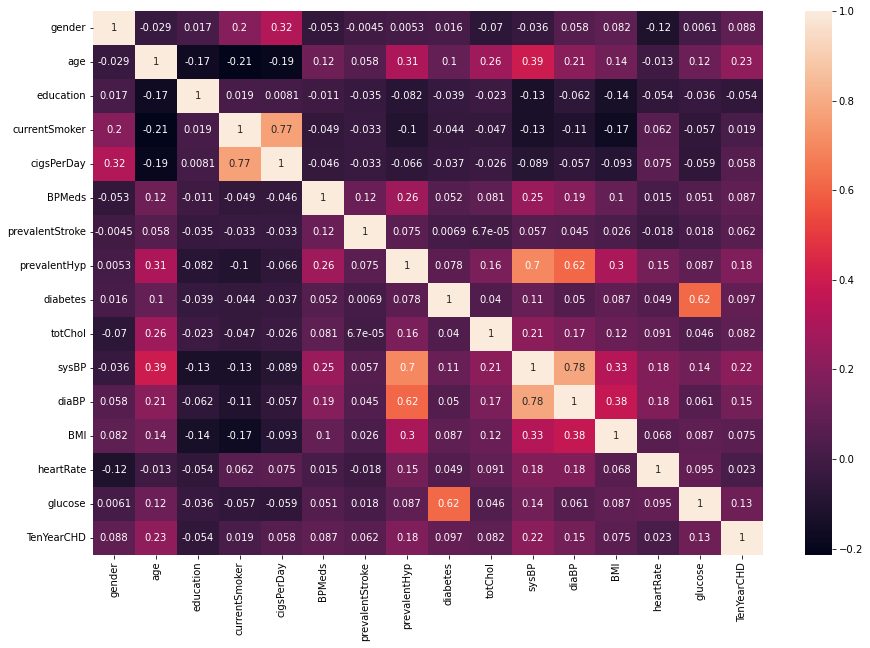

In [9]:
# Let's see if there's any correlation among features and the target
corrMatrix = patientInfo.corr()
fig,axes = plt.subplots(1,1)
fig.set_size_inches(15,10)
sns.heatmap(corrMatrix, annot=True)

In [10]:
# Checking for "TenYearCHD"
corrMatrix.TenYearCHD.sort_values()

education         -0.054059
currentSmoker      0.019456
heartRate          0.022913
cigsPerDay         0.057884
prevalentStroke    0.061810
BMI                0.075192
totChol            0.082184
BPMeds             0.087489
gender             0.088428
diabetes           0.097317
glucose            0.125544
diaBP              0.145299
prevalentHyp       0.177603
sysBP              0.216429
age                0.225256
TenYearCHD         1.000000
Name: TenYearCHD, dtype: float64

In [11]:
# We can't see any direct correlation, hence we'll go ahead and drop education column for now
patientInfo.drop(['education'],axis=1,inplace=True)
patientInfo.shape

(4238, 15)

Text(0, 0.5, 'diabetes')

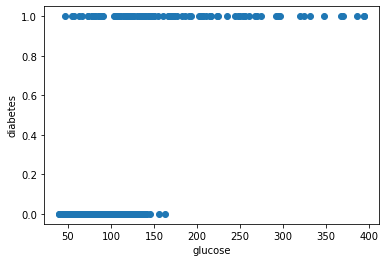

In [12]:
# Let's plot and see how the values are
plt.scatter(patientInfo.glucose,patientInfo.diabetes)
plt.xlabel('glucose')
plt.ylabel('diabetes')

We can say that for value of glucose nearly greater than 175, the value of diabetes is mostly 1.

In [13]:
patientInfo[(patientInfo['glucose'].isna()) & (patientInfo['diabetes']==1)].shape

(4, 15)

In [14]:
patientInfo[(patientInfo['glucose'].isna()) & (patientInfo['diabetes']==0)].shape

(384, 15)

In [15]:
# We see that almost 4 entries have glucose value to be Nan for diabetes = 1 and almost 384 with Nan Values
# for diabetes = 0, thus let's replace value of glucose for diabetes = 1 with mode of glucose values for diabetes = 1
# and same for glucose value for diabetes = 0
patientInfo[(~patientInfo['glucose'].isna()) & (patientInfo['diabetes']==1)]['glucose'].mode()

0    120.0
Name: glucose, dtype: float64

In [16]:
patientInfo[(~patientInfo['glucose'].isna()) & (patientInfo['diabetes']==0)]['glucose'].mode()

0    75.0
Name: glucose, dtype: float64

In [17]:
# Thus replacing values with 120 and 75
patientInfo.loc[(patientInfo['glucose'].isna()) & (patientInfo['diabetes']==1),'glucose'] = 120.0
patientInfo.loc[(patientInfo['glucose'].isna()) & (patientInfo['diabetes']==0),'glucose'] = 75.0
patientInfo.glucose.isna().sum()

0

In [18]:
# 'Glucose' appears to be highly correlated to 'diabetes', thus let's replace the missing values with LR model for
# 'Glucose' vs 'diabetes'
patientInfo.diabetes.unique()

array([0, 1])

## Cigsperday vs CurrentSmoker

In [19]:
patientInfo.cigsPerDay.unique(), patientInfo.currentSmoker.unique()

(array([ 0., 20., 30., 23., 15.,  9., 10.,  5., 35., 43.,  1., 40.,  3.,
         2., nan, 12.,  4., 18., 25., 60., 14., 45.,  8., 50., 13., 11.,
         7.,  6., 38., 29., 17., 16., 19., 70.]),
 array([0, 1]))

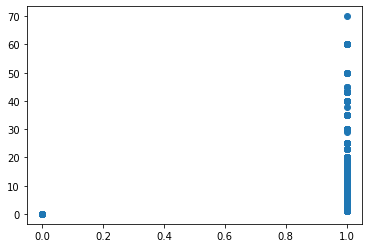

In [20]:
plt.scatter(patientInfo.currentSmoker,patientInfo.cigsPerDay)

We can see that people who smoke 1 or more cigrattes are usually current Smokers. We'll replace the value with the mode values

In [21]:
patientInfo[(patientInfo.cigsPerDay.isna()) & (patientInfo.currentSmoker==1)].shape

(29, 15)

In [22]:
# Since all the nan values are for CurrentSmokers let's replace it with the mode value of the distribution
patientInfo[(~patientInfo.cigsPerDay.isna()) & (patientInfo.currentSmoker==1)]['cigsPerDay'].mode()

0    20.0
Name: cigsPerDay, dtype: float64

In [23]:
patientInfo.loc[(patientInfo.cigsPerDay.isna()) & (patientInfo.currentSmoker==1),'cigsPerDay'] = 20.0
patientInfo.cigsPerDay.isna().sum()

0

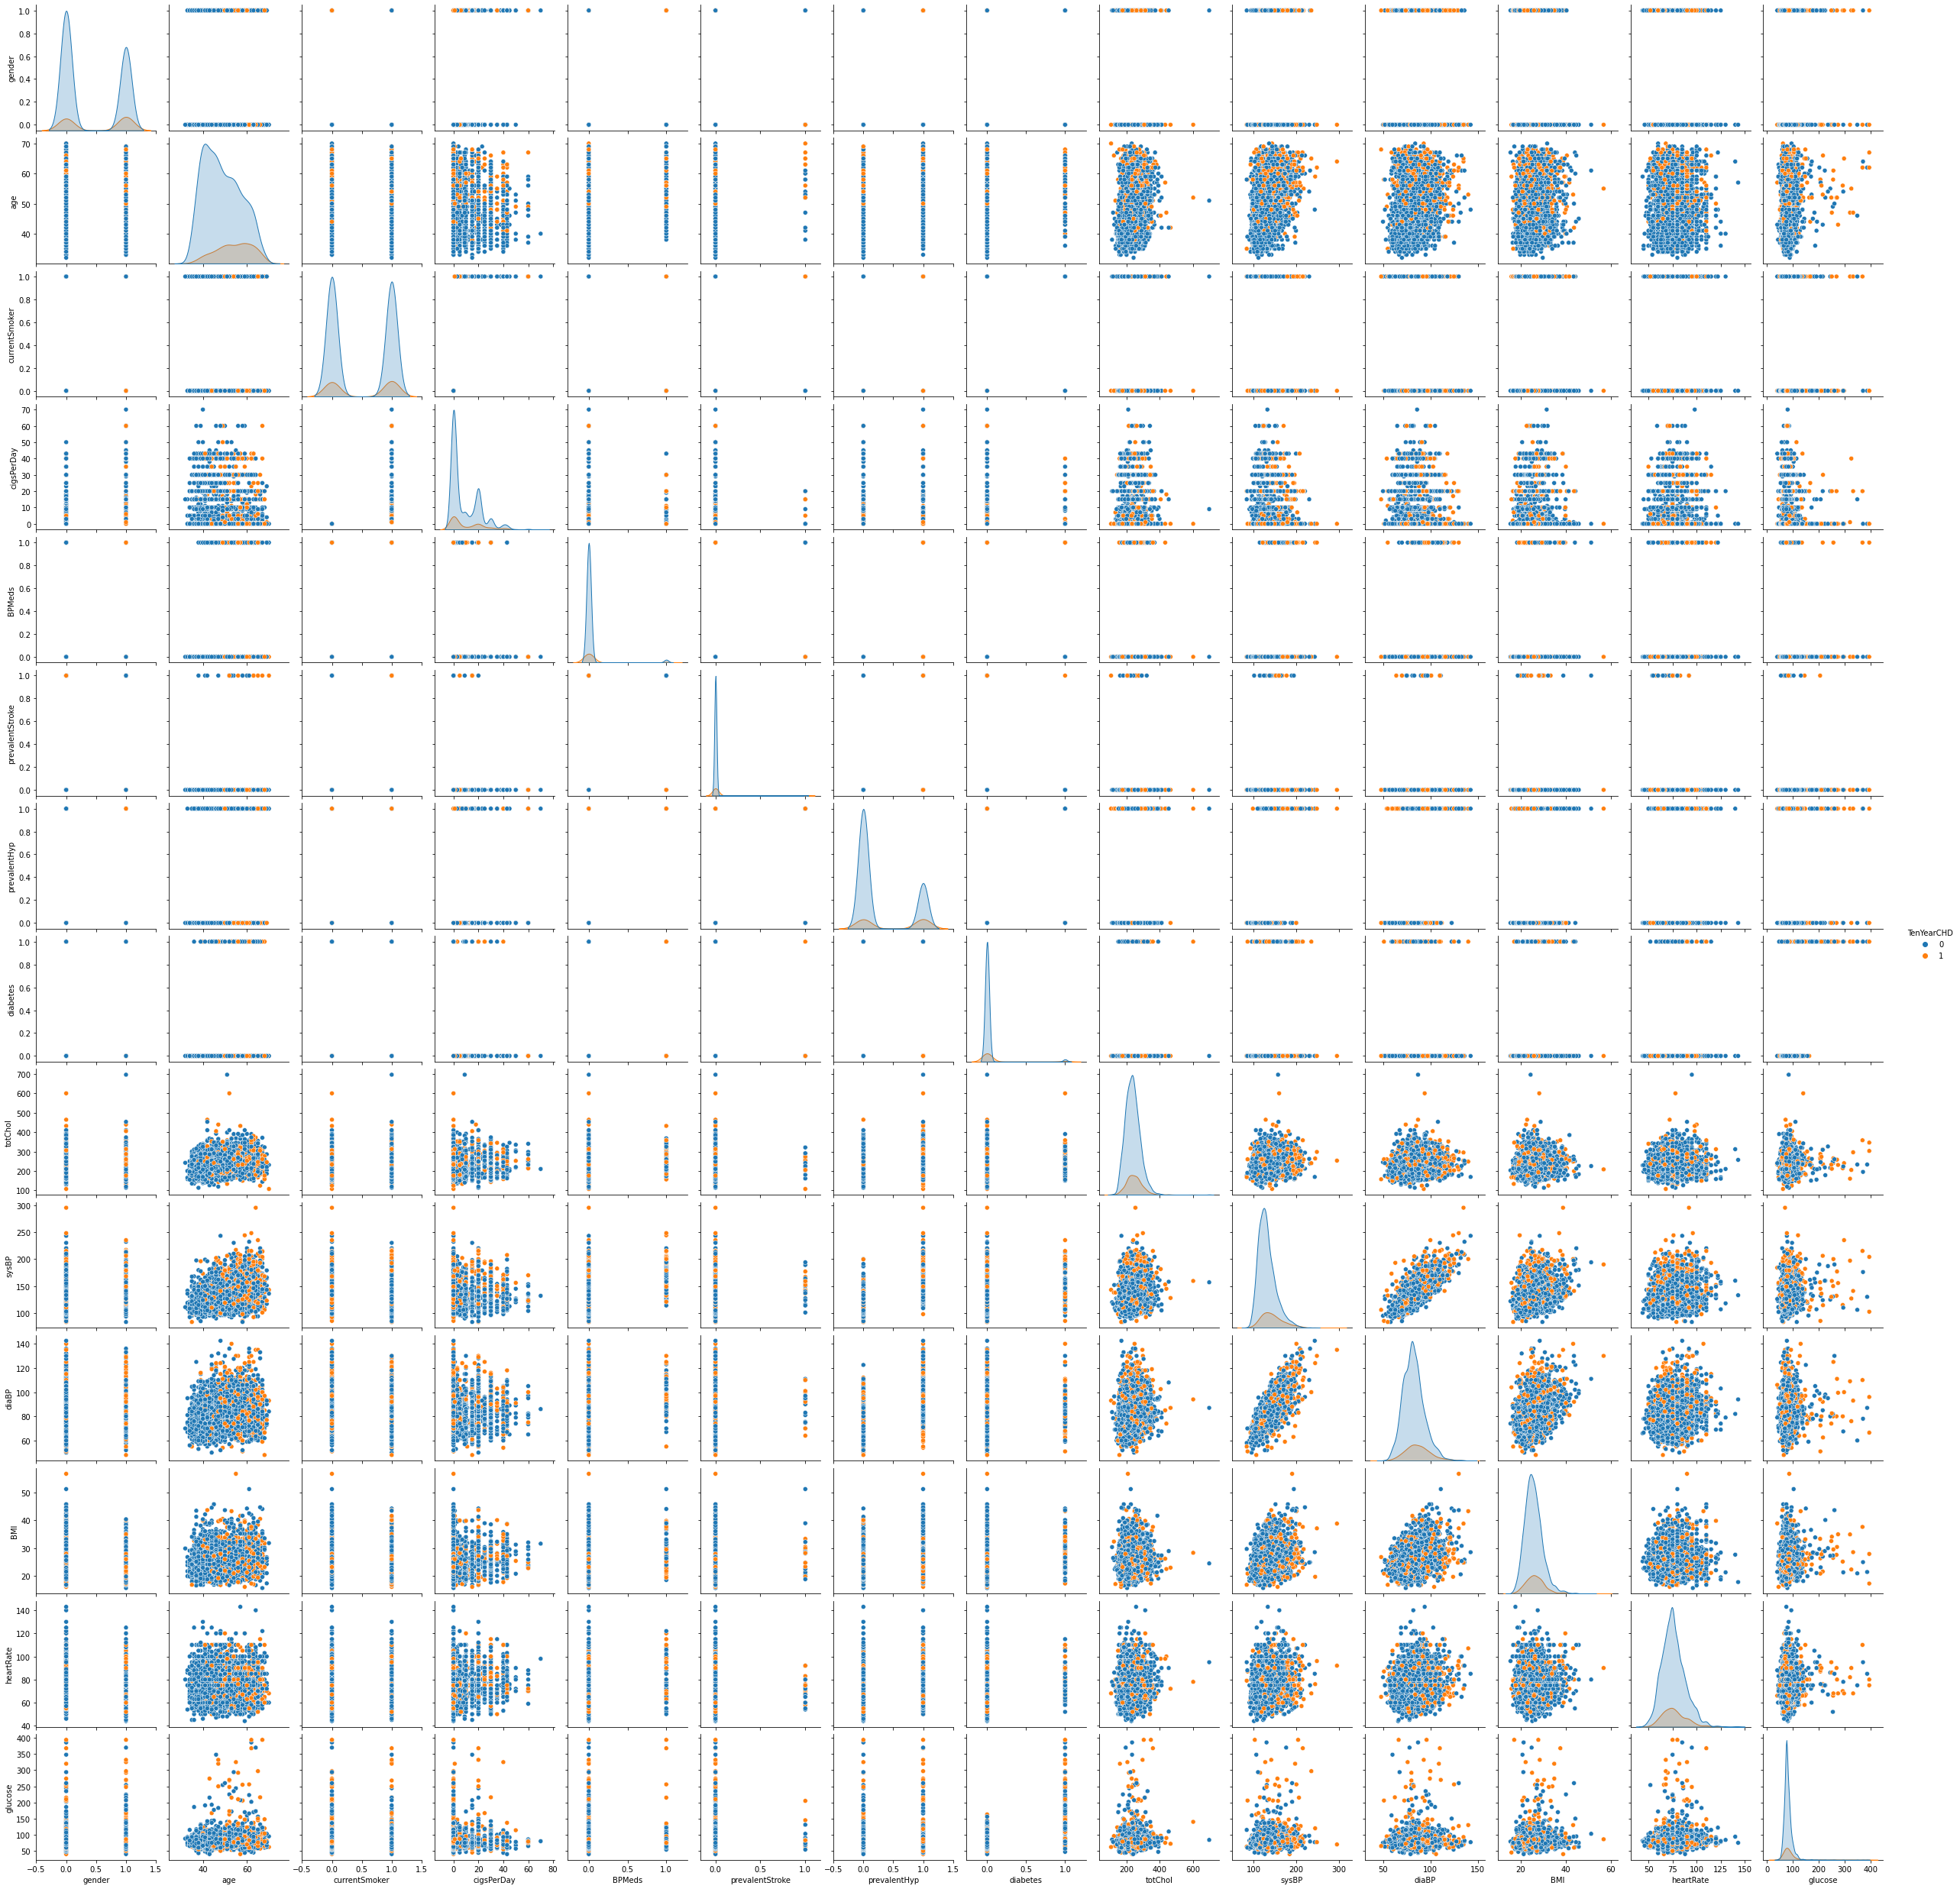

In [22]:
sns.pairplot(patientInfo,hue='TenYearCHD')

In [24]:
patientInfo[patientInfo['heartRate'].isna()]

,gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
689,1,64,1,18.0,0.0,0,1,0,219.0,172.5,75.0,29.29,NaN,91.0,1


<AxesSubplot:>

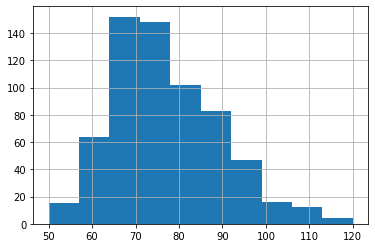

In [25]:
patientInfo[patientInfo['TenYearCHD']==1]['heartRate'].hist()

<AxesSubplot:>

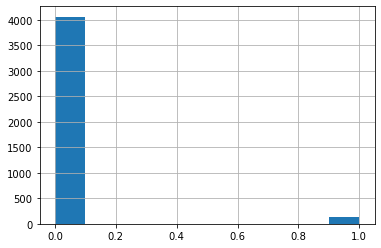

In [26]:
patientInfo['BPMeds'].hist()

In [27]:
# Filling BPMeds with the mode value
patientInfo.loc[patientInfo['BPMeds'].isna(),'BPMeds'] = 0.0

<AxesSubplot:>

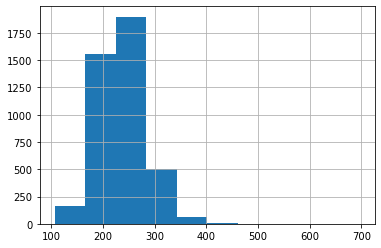

In [28]:
patientInfo['totChol'].hist()

In [29]:
# Replacing 'totChol' and 'bmi' missing values with mean
patientInfo['totChol'] = patientInfo['totChol'].fillna(patientInfo['totChol'].mean())
patientInfo['BMI'] = patientInfo['BMI'].fillna(patientInfo['BMI'].mean())
patientInfo['heartRate'] = patientInfo['heartRate'].fillna(patientInfo['heartRate'].mean())

In [30]:
patientInfo.isna().sum()

gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

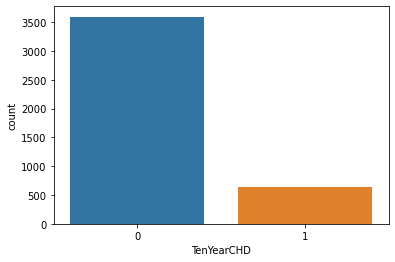

In [31]:
sns.countplot(x='TenYearCHD',data=patientInfo)

In [32]:
patientInfo['TenYearCHD'].value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

So the data largely has patients with no-heartd disease

In [33]:
# Describing the data and checking if we need to standardize the data
patientInfo.describe()

,gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000
mean,0.429212,49.584946,0.494101,9.078339,0.029259,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.371402,0.151958
std,0.495022,8.572160,0.500024,11.913780,0.168552,0.076587,0.462763,0.158316,44.326453,22.038097,11.910850,4.070953,12.025177,22.954745,0.359023
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,77.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.000000,89.875000,28.037500,83.000000,85.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Since the values are on different scale hence we need to standardize the data.

In [34]:
# Scaling the data
scaler = StandardScaler()
patientInfoStd = scaler.fit_transform(patientInfo.drop(['TenYearCHD'],axis=1))
patientInfoStd.shape

(4238, 14)

In [35]:
patientInfoStd = pd.DataFrame(patientInfoStd)
patientInfoStd.columns = patientInfo.columns[:-1]
patientInfoStd.head()

,gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1.153192,-1.234951,-0.988271,-0.762093,-0.173612,-0.077033,-0.671101,-0.162477,-0.941346,-1.195907,-1.082625,0.286943,0.342744,-0.190458
1,-0.867158,-0.418257,-0.988271,-0.762093,-0.173612,-0.077033,-0.671101,-0.162477,0.299595,-0.515187,-0.158988,0.719325,1.590275,-0.234027
2,1.153192,-0.184916,1.011868,0.916833,-0.173612,-0.077033,-0.671101,-0.162477,0.186782,-0.220209,-0.242955,-0.113502,-0.073099,-0.495442
3,-0.867158,1.331800,1.011868,1.756296,-0.173612,-0.077033,1.490089,-0.162477,-0.264469,0.800871,1.016549,0.682474,-0.904786,0.942339
4,-0.867158,-0.418257,1.011868,1.168672,-0.173612,-0.077033,-0.671101,-0.162477,1.089284,-0.106755,0.092912,-0.663807,0.758588,0.158095


## Selecting Features via Step Forward Feature Selection

In [46]:
patientInfoStd.isna().sum()

gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64

In [47]:
sfs = SFS(LogisticRegression(),
         k_features=6,
         forward=False,
         verbose=2,
         scoring='roc_auc',
         cv=3)

sfs.fit(patientInfoStd,patientInfo['TenYearCHD'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished

[2022-03-16 18:05:26] Features: 13/6 -- score: 0.7269050472563064[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.4s finished

[2022-03-16 18:05:26] Features: 12/6 -- score: 0.7274160718732724[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished

[2022-03-16 18:05:26] Features: 11/6 -- score: 0.7279705471591246[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(cv=3, estimator=LogisticRegression(), forward=False,
                          k_features=6, scoring='roc_auc', verbose=2)

In [48]:
# Checking the features selected
selFeatures = patientInfoStd.columns[list(sfs.k_feature_idx_)]
selFeatures

Index(['gender', 'age', 'cigsPerDay', 'prevalentHyp', 'diabetes', 'sysBP'], dtype='object')

## Selecting features based on Exhaustive Feature Selection

In [49]:
efs = EFS(LogisticRegression(),
          max_features=6,
          print_progress=True,
          scoring='roc_auc',
          cv=3)
efs.fit(patientInfoStd,patientInfo['TenYearCHD'])

Features: 3000/6475IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Features: 6475/6475

ExhaustiveFeatureSelector(cv=3, estimator=LogisticRegression(), max_features=6,
                          scoring='roc_auc')

In [50]:
efs.best_feature_names_

('gender', 'age', 'cigsPerDay', 'prevalentHyp', 'diabetes', 'sysBP')

We can't see much improvement in the model performance using the above set of features.

## Selecting Categorical Features based on Fisher Score

In [51]:
patientInfo.columns

Index(['gender', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [52]:
categoricalAttr = ['gender','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']
patientInfoCat = patientInfo[categoricalAttr]
patientInfoCat.head()

,gender,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes
0,1,0,0.0,0,0,0
1,0,0,0.0,0,0,0
2,1,1,0.0,0,0,0
3,0,1,0.0,0,1,0
4,0,1,0.0,0,0,0


In [53]:
fScore = chi2(patientInfoCat,patientInfo['TenYearCHD'])
fScore

(array([18.91521246,  0.81160326, 30.72303102, 16.09563773, 92.16785718,
        39.10371009]),
 array([1.36658566e-05, 3.67646670e-01, 2.97611565e-08, 6.02225977e-05,
        7.96276469e-22, 4.01879568e-10]))

The first set of values are the f-scores and the second set of values are the p-values. We can go ahead and eleminate all the feautes with p_values greater that $\alpha$=0.5

In [54]:
p_values = pd.Series(fScore[1])
p_values.index = categoricalAttr
p_values.sort_values(ascending=False) < 0.05

currentSmoker      False
prevalentStroke     True
gender              True
BPMeds              True
diabetes            True
prevalentHyp        True
dtype: bool

Thus we can go ahead and eliminate `currentSmoker` from the feature set.

## Performing ANOVA

In [55]:
univariate = f_classif(patientInfo.drop(['currentSmoker','TenYearCHD'],axis=1),patientInfo['TenYearCHD'])
univariate

(array([ 33.38417059, 226.42482952,  13.39608582,  31.87213613,
         16.24557424, 137.96685574,  40.50061522,  28.41161556,
        208.17180252,  91.35845441,  23.7570853 ,   2.22208427,
         65.46735494]),
 array([8.10654258e-09, 6.84500859e-50, 2.55222342e-04, 1.75431979e-08,
        5.66166353e-05, 2.26108813e-31, 2.17422179e-10, 1.03178295e-07,
        4.19533989e-46, 1.96883473e-21, 1.13291482e-06, 1.36123738e-01,
        7.64746684e-16]))

This also follows the same practise with 1st values representing the f_score and later ones representing the p_values.

In [56]:
univariteFeatures = pd.Series(univariate[1])
univariteFeatures.index = patientInfo.drop(['currentSmoker','TenYearCHD'],axis=1).columns
univariteFeatures.sort_values(ascending=False) < 0.05

heartRate          False
cigsPerDay          True
prevalentStroke     True
BMI                 True
totChol             True
BPMeds              True
gender              True
diabetes            True
glucose             True
diaBP               True
prevalentHyp        True
sysBP               True
age                 True
dtype: bool

By the above 2 methods we can go ahead and remove `currentSmoker` and `heartRate` features.

## Statistical Approach in Feature Selection

In [93]:
patientInfoConst = patientInfo.copy()
patientInfoConst.insert(0,'const',1.0)
patientInfoConst.head()

,const,gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [92]:
patientInfoConst.head()

,gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [81]:
from statsmodels.tools import add_constant
patientInfoConst = add_constant(patientInfo)
patientInfoConst.head()

,const,gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [61]:
st.chisqprob = lambda chisq, df : st.chi2(chisq, df)

In [37]:
models = sm.Logit(patientInfo.TenYearCHD,patientInfo[patientInfo.columns[:-1]])
result = models.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.399225
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4238
Model:                          Logit   Df Residuals:                     4224
Method:                           MLE   Df Model:                           13
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                 0.06305
Time:                        19:22:00   Log-Likelihood:                -1691.9
converged:                       True   LL-Null:                       -1805.8
Covariance Type:            nonrobust   LLR p-value:                 2.652e-41
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
gender              0.3659      0.097      3.781      0.000       0.176       0.556
age                 0.0290      0.005      5.327      0.000       0.018       0.040
currentSmoker      -0.2622      0.141     -1.854      0.064      -0.539       0.015
cigsPerDay          0.0228      0.006      3.994      0.000       0.012       0.034
BPMeds              0.3987      0.216      1.847      0.065      -0.024       0.822
prevalentStroke     0.9193      0.436      2.109      0.035       0.065       1.773
prevalentHyp        0.9586      0.115      8.342      0.000       0.733       1.184
diabetes            0.8921      0.279      3.202      0.001       0.346       1.438
totChol            -0.0018      0.001     -1.740      0.082      -0.004       0.000
sysBP               0.0121      0.004      3.446      0.001       0.005       0.019
diaBP              -0.0275      0.006     -4.868      0.000      -0.039      -0.016
BMI                -0.0501      0.011     -4.365      0.000      -0.073      -0.028
heartRate          -0.0208      0.004     -5.683      0.000      -0.028      -0.014
glucose             0.0012      0.002      0.590      0.555      -0.003       0.005
===================================================================================
"""

Thus we can see variables with higher P values and will be showing weak relationship with the probability of heart-disease.

### Feature Selection with Backward Elemination(P-value approach)

In [94]:
def backward_feat_elemination(df, target, cols):
    while len(cols)>0:
        model = sm.Logit(target,df[cols])
        result = model.fit(disp=0)
        large_p_val = round(result.pvalues,3).nlargest(1)
        print(large_p_val)
        if large_p_val[0] < 0.05:
            return result
        else:
            cols = cols.drop(large_p_val.index[0])

In [95]:
result = backward_feat_elemination(patientInfoConst, patientInfoConst.TenYearCHD, patientInfoConst.columns[:-1])

currentSmoker    0.859
dtype: float64
BMI    0.755
dtype: float64
heartRate    0.72
dtype: float64
diaBP    0.626
dtype: float64
diabetes    0.573
dtype: float64
BPMeds    0.248
dtype: float64
totChol    0.075
dtype: float64
prevalentHyp    0.055
dtype: float64
prevalentStroke    0.017
dtype: float64


In [96]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4238
Model:                          Logit   Df Residuals:                     4231
Method:                           MLE   Df Model:                            6
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                  0.1088
Time:                        19:47:51   Log-Likelihood:                -1609.4
converged:                       True   LL-Null:                       -1805.8
Covariance Type:            nonrobust   LLR p-value:                 9.741e-82
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.4551      0.389    -21.726      0.000      -9.218      -7.692
gender              0.4875      0.097      5.017      0.000       0.297       0.678
age                 0.0646      0.006     10.896      0.000       0.053       0.076
cigsPerDay          0.0210      0.004      5.460      0.000       0.013       0.029
prevalentStroke     1.0436      0.436      2.392      0.017       0.189       1.899
sysBP               0.0170      0.002      8.515      0.000       0.013       0.021
glucose             0.0077      0.002      4.740      0.000       0.005       0.011
===================================================================================
"""

Thus we can go ahead and select these features for our model.